In [1]:
# 실험 결과 백업 후 정리

import os
import shutil
import json
import pickle

# 현재 디스크 상황 확인
!df -h

# 실험 결과 백업
experiment_results = {}
result_folders = ['./results', './results_exp1']

print("실험 결과 백업 중...")
for folder in result_folders:
    if os.path.exists(folder):
        exp_name = folder.replace('./', '').replace('results_', '').replace('results', 'baseline')
        backup_data = {'folder': folder}
        
        # 중요 결과 파일들 백업
        for file_name in ['trainer_state.json', 'all_results.json', 'eval_results.json']:
            file_path = f"{folder}/{file_name}"
            if os.path.exists(file_path):
                with open(file_path, 'r') as f:
                    backup_data[file_name.replace('.json', '')] = json.load(f)
        
        experiment_results[exp_name] = backup_data
        print(f"{exp_name} 결과 백업 완료")

# 백업 파일 저장
with open('experiment_backup.pkl', 'wb') as f:
    pickle.dump(experiment_results, f)
with open('experiment_backup.json', 'w') as f:
    json.dump(experiment_results, f, indent=2, default=str)

print("백업 완료: experiment_backup.pkl/.json")

# 백업 결과 요약
print("\n백업된 실험 결과:")
for exp_name, data in experiment_results.items():
    print(f"{exp_name}:")
    if 'trainer_state' in data:
        logs = data['trainer_state'].get('log_history', [])
        eval_logs = [log for log in logs if 'eval_accuracy' in log]
        if eval_logs:
            best_acc = max([log['eval_accuracy'] for log in eval_logs])
            print(f"  최고 검증 정확도: {best_acc:.4f}")

# 폴더 삭제로 공간 확보
print("\n디스크 공간 확보 중...")
total_freed = 0
for folder in result_folders:
    if os.path.exists(folder):
        size = sum(os.path.getsize(os.path.join(dirpath, filename))
                  for dirpath, dirnames, filenames in os.walk(folder)
                  for filename in filenames) / (1024*1024)
        shutil.rmtree(folder)
        total_freed += size
        print(f"{folder} 삭제 완료 ({size:.1f}MB 절약)")

print(f"총 {total_freed:.1f}MB 절약")

# 정리 후 상황 확인
print("\n정리 후 디스크 상황:")
!df -h

Filesystem           Size  Used Avail Use% Mounted on
overlay               95G   26G   69G  28% /
tmpfs                 64M     0   64M   0% /dev
/dev/sda1             95G   26G   69G  28% /etc/hosts
shm                   64M     0   64M   0% /dev/shm
/dev/sdb              63G   18G   45G  29% /home/jovyan/work
modulabs-gcs-shared  1.0P     0  1.0P   0% /home/jovyan/data
tmpfs                 17G   12K   17G   1% /run/secrets/kubernetes.io/serviceaccount
tmpfs                 13G     0   13G   0% /proc/acpi
tmpfs                 13G     0   13G   0% /proc/scsi
tmpfs                 13G     0   13G   0% /sys/firmware
실험 결과 백업 중...
백업 완료: experiment_backup.pkl/.json

백업된 실험 결과:

디스크 공간 확보 중...
총 0.0MB 절약

정리 후 디스크 상황:
Filesystem           Size  Used Avail Use% Mounted on
overlay               95G   26G   69G  28% /
tmpfs                 64M     0   64M   0% /dev
/dev/sda1             95G   26G   69G  28% /etc/hosts
shm                   64M     0   64M   0% /dev/shm
/dev/sdb            

In [1]:
# 필요한 라이브러리 설치
!pip install datasets transformers torch matplotlib seaborn pandas numpy scikit-learn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.6/562.6 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 73.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.0/802.0 kB 42.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 20.0.0━━━━━━━━━━━━━━━━━━━  3/17 [pyarrow]
    Uninstalling pyarrow-20.0.0:━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  3/17 [pyarrow]
      Successfully uninstalled pyarrow-20.0.0━━━━━━━━━━━━━━━━━━━━━  3/17 [pyarrow]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17/17 [datasets]/17 [datasets]ers]ub]


In [2]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# 딥러닝 라이브러리
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Hugging Face 라이브러리
import datasets
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding
)

# 평가 메트릭
from sklearn.metrics import accuracy_score, classification_report

# GPU 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 디바이스: {device}")
print(f"PyTorch 버전: {torch.__version__}")
print("라이브러리 import 완료!")

사용 디바이스: cuda
PyTorch 버전: 2.7.1+cu118
라이브러리 import 완료!


In [3]:
!pip install tf-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 38.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 122.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 124.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 110.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23/23 [tf-keras]/23 [tf-keras]w]-py]a-server]


In [5]:
# NSMC 데이터셋 로드
print("NSMC 데이터셋 로드 중...")
nsmc_dataset = load_dataset('Blpeng/nsmc')
print(nsmc_dataset)

# 데이터셋 구조 확인
print("\n데이터셋 구조:")
print(f"Train: {len(nsmc_dataset['train'])} samples")
print(f"Test: {len(nsmc_dataset['test'])} samples")

# 첫 번째 샘플 확인
print("\n첫 번째 train 샘플:")
print(nsmc_dataset['train'][0])

print("\n첫 번째 test 샘플:")
print(nsmc_dataset['test'][0])

# 데이터 필드 확인
print("\n데이터 필드:")
print(nsmc_dataset['train'].features)

# 기본 통계 확인
train_data = nsmc_dataset['train']
test_data = nsmc_dataset['test']

print(f"\n레이블 분포 (Train):")
train_labels = [item['label'] for item in train_data]
print(f"긍정(1): {sum(train_labels)}")
print(f"부정(0): {len(train_labels) - sum(train_labels)}")

print(f"\n레이블 분포 (Test):")
test_labels = [item['label'] for item in test_data]
print(f"긍정(1): {sum(test_labels)}")
print(f"부정(0): {len(test_labels) - sum(test_labels)}")

NSMC 데이터셋 로드 중...


Repo card metadata block was not found. Setting CardData to empty.


DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['Unnamed: 0', 'id', 'document', 'label'],
        num_rows: 50000
    })
})

데이터셋 구조:
Train: 150000 samples
Test: 50000 samples

첫 번째 train 샘플:
{'Unnamed: 0': 0, 'id': 9976970, 'document': '아 더빙.. 진짜 짜증나네요 목소리', 'label': 0}

첫 번째 test 샘플:
{'Unnamed: 0': 0, 'id': 6270596, 'document': '굳 ㅋ', 'label': 1}

데이터 필드:
{'Unnamed: 0': Value('int64'), 'id': Value('int64'), 'document': Value('string'), 'label': Value('int64')}

레이블 분포 (Train):
긍정(1): 74827
부정(0): 75173

레이블 분포 (Test):
긍정(1): 25173
부정(0): 24827


In [6]:
# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')

# 모델 로드 (분류용)
model = AutoModelForSequenceClassification.from_pretrained(
    'klue/bert-base', 
    num_labels=2
)

# 모델을 GPU로 이동
model = model.to(device)

print("모델 및 토크나이저 로드 완료!")
print(f"Vocabulary 크기: {tokenizer.vocab_size}")
print(f"최대 시퀀스 길이: {tokenizer.model_max_length}")
print(f"모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")

# 토크나이저 테스트
test_text = "이 영화 정말 재미있어요!"
encoded = tokenizer(test_text, return_tensors="pt")
print(f"\n테스트 텍스트: {test_text}")
print(f"토크나이징 결과: {encoded['input_ids']}")
print(f"디코딩 결과: {tokenizer.decode(encoded['input_ids'][0])}")

tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


모델 및 토크나이저 로드 완료!
Vocabulary 크기: 32000
최대 시퀀스 길이: 512
모델 파라미터 수: 110,618,882

테스트 텍스트: 이 영화 정말 재미있어요!
토크나이징 결과: tensor([[    2,  1504,  3771,  3944,  6001, 10283,     5,     3]])
디코딩 결과: [CLS] 이 영화 정말 재미있어요! [SEP]


In [7]:
# 5단계 디버깅: 데이터셋 구조 확인

print("데이터셋 구조 상세 확인:")
print("\nTrain 데이터셋 features:")
print(nsmc_dataset['train'].features)

print("\nTrain 첫 번째 샘플:")
print(nsmc_dataset['train'][0])

print("\nTrain 샘플의 키들:")
print(list(nsmc_dataset['train'][0].keys()))

print("\nTest 첫 번째 샘플:")
print(nsmc_dataset['test'][0])

데이터셋 구조 상세 확인:

Train 데이터셋 features:
{'Unnamed: 0': Value('int64'), 'id': Value('int64'), 'document': Value('string'), 'label': Value('int64')}

Train 첫 번째 샘플:
{'Unnamed: 0': 0, 'id': 9976970, 'document': '아 더빙.. 진짜 짜증나네요 목소리', 'label': 0}

Train 샘플의 키들:
['Unnamed: 0', 'id', 'document', 'label']

Test 첫 번째 샘플:
{'Unnamed: 0': 0, 'id': 6270596, 'document': '굳 ㅋ', 'label': 1}


In [8]:
# 5단계: 데이터 전처리 및 토크나이징

# 데이터 정리 함수
def filter_and_clean_data(example):
    """빈 문자열이나 None 값 필터링"""
    return example['document'] is not None and len(example['document'].strip()) > 0

# 데이터 필터링
print("데이터 필터링 중...")
clean_train = nsmc_dataset['train'].filter(filter_and_clean_data)
clean_test = nsmc_dataset['test'].filter(filter_and_clean_data)

print(f"필터링 후 Train: {len(clean_train)} samples")
print(f"필터링 후 Test: {len(clean_test)} samples")

def preprocess_function(examples):
    """토크나이징 함수"""
    # 텍스트가 리스트인지 확인하고 처리
    texts = examples['document']
    if isinstance(texts, str):
        texts = [texts]
    
    return tokenizer(
        texts, 
        truncation=True, 
        padding=False,  # 동적 패딩 사용
        max_length=128
    )

print("데이터 토크나이징 중...")

# 데이터셋 토크나이징
tokenized_train = clean_train.map(preprocess_function, batched=True)
tokenized_test = clean_test.map(preprocess_function, batched=True)

# 필요없는 컬럼 제거 (document, Unnamed: 0, id 제거)
tokenized_train = tokenized_train.remove_columns(['document', 'Unnamed: 0', 'id'])
tokenized_test = tokenized_test.remove_columns(['document', 'Unnamed: 0', 'id'])

# Train에서 validation 분할 (8:2)
train_val_split = tokenized_train.train_test_split(test_size=0.2, seed=42)

# 최종 데이터셋 구성
final_dataset = DatasetDict({
    'train': train_val_split['train'],
    'validation': train_val_split['test'],
    'test': tokenized_test
})

print("데이터 전처리 완료!")
print(f"Train: {len(final_dataset['train'])} samples")
print(f"Validation: {len(final_dataset['validation'])} samples") 
print(f"Test: {len(final_dataset['test'])} samples")

# 첫 번째 토크나이징된 샘플 확인
print(f"\n토크나이징된 첫 번째 샘플:")
sample = final_dataset['train'][0]
print(f"input_ids 길이: {len(sample['input_ids'])}")
print(f"attention_mask 길이: {len(sample['attention_mask'])}")
print(f"label: {sample['label']}")

데이터 필터링 중...


Filter:   0%|          | 0/150000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

필터링 후 Train: 149995 samples
필터링 후 Test: 49997 samples
데이터 토크나이징 중...


Map:   0%|          | 0/149995 [00:00<?, ? examples/s]

Map:   0%|          | 0/49997 [00:00<?, ? examples/s]

데이터 전처리 완료!
Train: 119996 samples
Validation: 29999 samples
Test: 49997 samples

토크나이징된 첫 번째 샘플:
input_ids 길이: 11
attention_mask 길이: 11
label: 1


In [9]:
from transformers import EarlyStoppingCallback
import matplotlib.pyplot as plt

# 평가 메트릭 함수
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    return {'accuracy': accuracy}

# 데이터 콜레이터 (동적 패딩)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# eval_strategy 포함 훈련 설정
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps=100,
    eval_strategy="steps",  # 단계별 평가
    eval_steps=5000,         # 500스텝마다 평가
    save_steps=5000,         # 500스텝마다 저장 (eval_steps와 맞춤)
    save_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    seed=42
)

# Trainer 생성 (Early Stopping 포함)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_dataset['train'],
    eval_dataset=final_dataset['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# 시각화 함수
def plot_training_results(trainer, title="Training Results"):
    """훈련 결과 시각화"""
    logs = trainer.state.log_history
    
    train_loss = []
    eval_accuracy = []
    eval_loss = []
    steps = []
    eval_steps = []
    
    for log in logs:
        if 'loss' in log and 'step' in log:
            train_loss.append(log['loss'])
            steps.append(log['step'])
        if 'eval_accuracy' in log and 'step' in log:
            eval_accuracy.append(log['eval_accuracy'])
            eval_loss.append(log['eval_loss'])
            eval_steps.append(log['step'])
    
    # 그래프 그리기
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # 훈련 손실
    if train_loss:
        ax1.plot(steps, train_loss, 'b-', label='Training Loss', alpha=0.7)
        ax1.set_xlabel('Steps')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    
    # 검증 정확도와 손실
    if eval_accuracy:
        ax2_twin = ax2.twinx()
        
        line1 = ax2.plot(eval_steps, eval_accuracy, 'g-', label='Validation Accuracy')
        line2 = ax2_twin.plot(eval_steps, eval_loss, 'r-', label='Validation Loss', alpha=0.7)
        
        ax2.set_xlabel('Steps')
        ax2.set_ylabel('Accuracy', color='g')
        ax2_twin.set_ylabel('Loss', color='r')
        ax2.set_title('Validation Metrics')
        
        # 범례 합치기
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax2.legend(lines, labels, loc='center right')
        
        ax2.grid(True, alpha=0.3)
        
        print(f"최고 검증 정확도: {max(eval_accuracy):.4f}")
        print(f"최종 검증 정확도: {eval_accuracy[-1]:.4f}")
    
    plt.tight_layout()
    plt.show()

print("훈련 설정 완료!")
print(f"에포크: {training_args.num_train_epochs}")
print(f"배치 크기: {training_args.per_device_train_batch_size}")
print(f"평가 전략: {training_args.eval_strategy}")
print(f"평가 주기: {training_args.eval_steps} 스텝마다")
print(f"Early Stopping: 활성화 (patience=3)")

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=0.26.0'`

In [ ]:
print("모델 훈련 시작...")
print(f"훈련 샘플 수: {len(final_dataset['train'])}")
print(f"검증 샘플 수: {len(final_dataset['validation'])}")
print(f"평가 주기: 500스텝마다")
print(f"Early Stopping: 3회 연속 개선 없으면 중단")

# 훈련 시작 시간 기록
start_time = time.time()

# 훈련 실행
try:
    print("\n훈련 진행 중...")
    train_result = trainer.train()
    print("훈련 완료!")
except Exception as e:
    print(f"훈련 중 오류 발생: {e}")
    
# 훈련 시간 계산
training_time = time.time() - start_time
print(f"총 훈련 시간: {training_time:.2f}초 ({training_time/60:.1f}분)")

# 최종 평가
print("\n최종 평가 진행 중...")

# 검증 데이터 평가
eval_results = trainer.evaluate(final_dataset['validation'])
print(f"최종 검증 정확도: {eval_results['eval_accuracy']:.4f}")
print(f"최종 검증 손실: {eval_results['eval_loss']:.4f}")

# 테스트 데이터 평가  
test_results = trainer.evaluate(final_dataset['test'])
print(f"최종 테스트 정확도: {test_results['eval_accuracy']:.4f}")
print(f"최종 테스트 손실: {test_results['eval_loss']:.4f}")

# 훈련 과정에서의 최고 성능 확인
logs = trainer.state.log_history
eval_accuracies = [log['eval_accuracy'] for log in logs if 'eval_accuracy' in log]
if eval_accuracies:
    best_val_accuracy = max(eval_accuracies)
    print(f"훈련 중 최고 검증 정확도: {best_val_accuracy:.4f}")

# 결과 요약
print("\n" + "="*50)
print("훈련 결과 요약")
print("="*50)
print(f"훈련 시간: {training_time:.2f}초 ({training_time/60:.1f}분)")
print(f"최고 검증 정확도: {best_val_accuracy:.4f}")
print(f"최종 검증 정확도: {eval_results['eval_accuracy']:.4f}")
print(f"최종 테스트 정확도: {test_results['eval_accuracy']:.4f}")

# 목표 달성 여부 확인
target_accuracy = 0.90
if best_val_accuracy >= target_accuracy:
    print(f"목표 정확도 {target_accuracy:.0%} 달성!")
else:
    print(f"목표 정확도 {target_accuracy:.0%} 미달성")
    print(f"현재: {best_val_accuracy:.1%} (목표까지 {target_accuracy-best_val_accuracy:.1%} 부족)")

# 결과 저장 (다음 단계에서 사용)
baseline_results = {
    'training_time': training_time,
    'best_val_accuracy': best_val_accuracy,
    'final_val_accuracy': eval_results['eval_accuracy'],
    'test_accuracy': test_results['eval_accuracy']
}

# 시각화
print("\n훈련 과정 시각화...")
try:
    plot_training_results(trainer, "KLUE BERT NSMC Fine-tuning")
except Exception as e:
    print(f"시각화 중 오류: {e}")

print("\n기본 모델 훈련 완료!")

In [ ]:
from torch.utils.data import DataLoader
import torch

# Bucketing을 위한 커스텀 DataCollator
class BucketingDataCollator:
    """길이별 Bucketing을 수행하는 DataCollator"""
    
    def __init__(self, tokenizer, bucket_boundaries=[32, 64, 128, 256]):
        self.tokenizer = tokenizer
        self.bucket_boundaries = bucket_boundaries
        
    def __call__(self, features):
        # 배치 내 최대 길이 찾기
        lengths = [len(f['input_ids']) for f in features]
        max_length = max(lengths)
        
        # 적절한 버킷 크기 결정
        bucket_size = min([b for b in self.bucket_boundaries if b >= max_length], 
                         default=max(self.bucket_boundaries))
        
        # 배치 생성
        batch = {}
        
        # input_ids 패딩
        input_ids = []
        for f in features:
            padded = f['input_ids'] + [self.tokenizer.pad_token_id] * (bucket_size - len(f['input_ids']))
            input_ids.append(padded)
        batch['input_ids'] = torch.tensor(input_ids)
        
        # attention_mask 생성
        attention_mask = []
        for f in features:
            mask = [1] * len(f['input_ids']) + [0] * (bucket_size - len(f['input_ids']))
            attention_mask.append(mask)
        batch['attention_mask'] = torch.tensor(attention_mask)
        
        # token_type_ids (있는 경우)
        if 'token_type_ids' in features[0]:
            token_type_ids = []
            for f in features:
                padded = f['token_type_ids'] + [0] * (bucket_size - len(f['token_type_ids']))
                token_type_ids.append(padded)
            batch['token_type_ids'] = torch.tensor(token_type_ids)
        
        # labels
        batch['labels'] = torch.tensor([f['label'] for f in features])
        
        return batch

# 새로운 모델 초기화 (공정한 비교를 위해)
print("Bucketing용 새 모델 로드 중...")
bucketing_model = AutoModelForSequenceClassification.from_pretrained(
    'klue/bert-base', 
    num_labels=2
)
bucketing_model = bucketing_model.to(device)

# Bucketing DataCollator 생성
bucketing_data_collator = BucketingDataCollator(
    tokenizer=tokenizer,
    bucket_boundaries=[32, 64, 128, 256]
)

# Bucketing 훈련 설정 (기본 설정과 동일하게)
bucketing_training_args = TrainingArguments(
    output_dir='./results_bucketing',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=500,
    save_steps=500,
    save_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    seed=42
)

# Bucketing Trainer 생성
bucketing_trainer = Trainer(
    model=bucketing_model,
    args=bucketing_training_args,
    train_dataset=final_dataset['train'],
    eval_dataset=final_dataset['validation'],
    tokenizer=tokenizer,
    data_collator=bucketing_data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("Bucketing 설정 완료!")
print(f"버킷 경계: {bucketing_data_collator.bucket_boundaries}")
print(f"기본 설정과 동일한 하이퍼파라미터 사용")

# Bucketing 훈련 실행
print("\nBucketing 모델 훈련 시작...")
bucketing_start_time = time.time()

try:
    bucketing_train_result = bucketing_trainer.train()
    print("Bucketing 훈련 완료!")
except Exception as e:
    print(f"Bucketing 훈련 중 오류: {e}")

bucketing_training_time = time.time() - bucketing_start_time
print(f"Bucketing 훈련 시간: {bucketing_training_time:.2f}초 ({bucketing_training_time/60:.1f}분)")

# Bucketing 모델 평가
print("\nBucketing 모델 평가 중...")
bucketing_eval_results = bucketing_trainer.evaluate(final_dataset['validation'])
bucketing_test_results = bucketing_trainer.evaluate(final_dataset['test'])

# Bucketing 최고 성능 확인
bucketing_logs = bucketing_trainer.state.log_history
bucketing_eval_accuracies = [log['eval_accuracy'] for log in bucketing_logs if 'eval_accuracy' in log]
bucketing_best_val_accuracy = max(bucketing_eval_accuracies) if bucketing_eval_accuracies else 0

print(f"Bucketing 최고 검증 정확도: {bucketing_best_val_accuracy:.4f}")
print(f"Bucketing 최종 검증 정확도: {bucketing_eval_results['eval_accuracy']:.4f}")
print(f"Bucketing 테스트 정확도: {bucketing_test_results['eval_accuracy']:.4f}")

# 결과 저장
bucketing_results = {
    'training_time': bucketing_training_time,
    'best_val_accuracy': bucketing_best_val_accuracy,
    'final_val_accuracy': bucketing_eval_results['eval_accuracy'],
    'test_accuracy': bucketing_test_results['eval_accuracy']
}

print("\nBucketing 모델 훈련 및 평가 완료!")

In [ ]:
!sudo apt-get update
!sudo apt-get install -y fonts-nanum fonts-nanum-coding fonts-nanum-extra

In [ ]:
# 한글 폰트 최종 해결

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 방법 1: 런타임 재시작 후 폰트 설정
import matplotlib
matplotlib.font_manager.fontManager.__init__()

# 방법 2: 직접 폰트 경로 지정
try:
    # 나눔고딕 폰트 직접 지정
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = font_prop.get_name()
    print("나눔고딕 직접 경로로 설정 완료")
except:
    # 방법 3: 시스템 폰트 검색
    font_list = [f.name for f in fm.fontManager.ttflist]
    korean_fonts = [f for f in font_list if 'Nanum' in f or 'Gothic' in f]
    print(f"사용 가능한 한글 폰트: {korean_fonts}")
    
    if korean_fonts:
        plt.rcParams['font.family'] = korean_fonts[0]
        print(f"{korean_fonts[0]} 폰트 설정")
    else:
        # 방법 4: 우분투 기본 한글 폰트
        plt.rcParams['font.family'] = 'Malgun Gothic'

plt.rcParams['axes.unicode_minus'] = False

# 테스트
plt.figure(figsize=(8, 5))
plt.bar(['기본 모델', 'Bucketing 모델'], [90.23, 90.15])
plt.title('한글 폰트 테스트')
plt.ylabel('정확도 (%)')
plt.show()

print("한글 폰트 설정 완료!")

In [ ]:
# 9단계: 기본 모델 vs Bucketing 모델 비교 분석

import pandas as pd
import matplotlib.pyplot as plt

# 결과 데이터 정리 (실제 결과로 업데이트)
baseline_results = {
    'training_time': 5064.84  # 기본 모델 훈련 시간 (실제 값으로 업데이트 필요)
    'best_val_accuracy': 0.902297,  # 90.23%
    'test_accuracy': 0.902297  # 실제 테스트 결과로 업데이트 필요
}

bucketing_results = {
    'training_time': 5960.62,  # 99.3분
    'best_val_accuracy': 0.9015,  # 90.15%
    'test_accuracy': 0.9001   # 90.01%
}

print("="*60)
print("기본 모델 vs Bucketing 모델 비교 분석")
print("="*60)

# 성능 비교
print("\n1. 성능 비교")
print("-" * 30)
print(f"기본 모델:")
print(f"  검증 정확도: {baseline_results['best_val_accuracy']:.4f} ({baseline_results['best_val_accuracy']:.2%})")
print(f"  테스트 정확도: {baseline_results['test_accuracy']:.4f} ({baseline_results['test_accuracy']:.2%})")

print(f"\nBucketing 모델:")
print(f"  검증 정확도: {bucketing_results['best_val_accuracy']:.4f} ({bucketing_results['best_val_accuracy']:.2%})")
print(f"  테스트 정확도: {bucketing_results['test_accuracy']:.4f} ({bucketing_results['test_accuracy']:.2%})")

# 성능 차이 계산
val_diff = bucketing_results['best_val_accuracy'] - baseline_results['best_val_accuracy']
test_diff = bucketing_results['test_accuracy'] - baseline_results['test_accuracy']

print(f"\n성능 차이:")
print(f"  검증 정확도 차이: {val_diff:+.4f} ({val_diff*100:+.2f}%p)")
print(f"  테스트 정확도 차이: {test_diff:+.4f} ({test_diff*100:+.2f}%p)")

# 시간 비교 (기본 모델 시간이 있는 경우)
if baseline_results['training_time'] > 0:
    print("\n2. 훈련 시간 비교")
    print("-" * 30)
    time_diff = bucketing_results['training_time'] - baseline_results['training_time']
    time_ratio = bucketing_results['training_time'] / baseline_results['training_time']
    
    print(f"기본 모델: {baseline_results['training_time']:.2f}초 ({baseline_results['training_time']/60:.1f}분)")
    print(f"Bucketing 모델: {bucketing_results['training_time']:.2f}초 ({bucketing_results['training_time']/60:.1f}분)")
    print(f"시간 차이: {time_diff:+.2f}초 ({time_ratio:.2f}배)")

# 목표 달성 여부
print("\n3. 목표 달성 여부")
print("-" * 30)
target = 0.90

baseline_achieved = baseline_results['best_val_accuracy'] >= target
bucketing_achieved = bucketing_results['best_val_accuracy'] >= target

print(f"목표 정확도: {target:.0%}")
print(f"기본 모델: {'달성' if baseline_achieved else '미달성'}")
print(f"Bucketing 모델: {'달성' if bucketing_achieved else '미달성'}")

# Trade-off 분석
print("\n4. Trade-off 분석")
print("-" * 30)

if abs(val_diff) < 0.005:  # 0.5% 미만 차이
    print("성능 차이가 매우 작음 (0.5% 미만)")
    if bucketing_results['training_time'] > baseline_results['training_time']:
        print("결론: Bucketing이 성능 개선 없이 훈련 시간만 증가시킴")
    else:
        print("결론: Bucketing이 성능 유지하면서 훈련 시간 단축")
elif val_diff > 0:
    print(f"Bucketing이 성능을 {val_diff*100:.2f}%p 향상시킴")
else:
    print(f"Bucketing이 성능을 {abs(val_diff)*100:.2f}%p 하락시킴")

# 실제 관찰된 결과
print("\n5. 실제 관찰된 결과")
print("-" * 30)
print("Bucketing 모델:")
print(f"- 검증 정확도: 90.15% (기본 대비 -0.08%p)")
print(f"- 테스트 정확도: 90.01%")
print(f"- 훈련 시간: 99.3분")
print("\n분석:")
print("- 성능: 기본 모델과 거의 동일한 수준")
print("- 시간: 상당히 오래 걸림 (약 1.5시간)")
print("- Bucketing의 효과가 미미하거나 오히려 부정적일 수 있음")

# 비교 테이블 생성
comparison_df = pd.DataFrame({
    '모델': ['기본 모델', 'Bucketing 모델'],
    '검증 정확도': [f"{baseline_results['best_val_accuracy']:.4f}", f"{bucketing_results['best_val_accuracy']:.4f}"],
    '테스트 정확도': [f"{baseline_results['test_accuracy']:.4f}", f"{bucketing_results['test_accuracy']:.4f}"],
    '훈련 시간(분)': [f"{baseline_results['training_time']/60:.1f}", f"{bucketing_results['training_time']/60:.1f}"]
})

print("\n6. 결과 요약 테이블")
print("-" * 30)
print(comparison_df.to_string(index=False))

# 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 정확도 비교
models = ['기본 모델', 'Bucketing']
val_accs = [baseline_results['best_val_accuracy'], bucketing_results['best_val_accuracy']]
test_accs = [baseline_results['test_accuracy'], bucketing_results['test_accuracy']]

x = range(len(models))
width = 0.35

ax1.bar([i - width/2 for i in x], val_accs, width, label='검증 정확도', alpha=0.8)
ax1.bar([i + width/2 for i in x], test_accs, width, label='테스트 정확도', alpha=0.8)
ax1.set_ylabel('정확도')
ax1.set_title('모델별 정확도 비교')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0.89, 0.91)

# 훈련 시간 비교 (기본 모델 시간이 있는 경우만)
if baseline_results['training_time'] > 0:
    times = [baseline_results['training_time']/60, bucketing_results['training_time']/60]
    ax2.bar(models, times, alpha=0.8, color=['skyblue', 'orange'])
    ax2.set_ylabel('훈련 시간 (분)')
    ax2.set_title('모델별 훈련 시간 비교')
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, '기본 모델\n훈련 시간\n정보 없음', 
             ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('훈련 시간 비교')

plt.tight_layout()
plt.show()

print("\n7. 결론")
print("-" * 30)
print("1. 두 모델 모두 90% 목표 정확도를 달성")
print("2. Bucketing은 성능 개선 효과가 미미함")
print("3. 현재 설정에서는 Bucketing의 이점이 크지 않음")
print("4. 데이터셋이나 모델 특성상 기본 패딩이 더 효율적일 수 있음")

In [ ]:
# ========================================
# 실험 1: 하이퍼파라미터 튜닝 (과적합 해결)
# 목적: train/val loss 격차 줄이기
# 변경: lr=0.00001, weight_decay=0.1, batch=32
# ========================================

from transformers import EarlyStoppingCallback
import pandas as pd

# 확장된 평가 메트릭
def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted'),
        'precision': precision_score(labels, predictions, average='weighted'),
        'recall': recall_score(labels, predictions, average='weighted'),
        'mcc': matthews_corrcoef(labels, predictions)
    }

# 모델 및 설정
exp1_model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels=2).to(device)

exp1_training_args = TrainingArguments(
    output_dir='./results_exp1',
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=0.00001,
    weight_decay=0.1,
    warmup_steps=500,
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=1000,  # 1000스텝마다 평가
    save_steps=1000,
    save_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    seed=42
)

exp1_trainer = Trainer(
    model=exp1_model,
    args=exp1_training_args,
    train_dataset=final_dataset['train'],
    eval_dataset=final_dataset['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# 훈련 실행
print("실험 1 훈련 시작...")
start_time = time.time()
exp1_trainer.train()
training_time = time.time() - start_time

# 결과 수집 및 표 생성
logs = exp1_trainer.state.log_history
eval_results = exp1_trainer.evaluate(final_dataset['validation'])
test_results = exp1_trainer.evaluate(final_dataset['test'])

# 에포크별 결과 테이블 생성
epoch_data = []
for log in logs:
    if 'eval_accuracy' in log:
        # 해당 스텝의 train loss 찾기
        train_log = next((l for l in logs if 'loss' in l and l.get('step', 0) <= log['step'] and 'eval_loss' not in l), {})
        
        epoch_data.append({
            'Epoch': len(epoch_data) + 1,
            'Training Loss': train_log.get('loss', 0),
            'Validation Loss': log['eval_loss'],
            'Accuracy': log['eval_accuracy'],
            'F1': log['eval_f1'],
            'Precision': log['eval_precision'],
            'Recall': log['eval_recall'],
            'Matthews Correlation': log['eval_mcc']
        })

# 결과 테이블 출력
df = pd.DataFrame(epoch_data)
print("\n" + "="*80)
print("실험 1 결과 (에포크별)")
print("="*80)
print(df.round(6).to_string(index=False))

# 최종 테스트 결과
print(f"\n최종 테스트 결과:")
print(f"Accuracy: {test_results['eval_accuracy']:.6f}")
print(f"F1: {test_results['eval_f1']:.6f}")
print(f"Precision: {test_results['eval_precision']:.6f}")
print(f"Recall: {test_results['eval_recall']:.6f}")
print(f"Matthews Correlation: {test_results['eval_mcc']:.6f}")

# 과적합 개선 효과
train_losses = [log['loss'] for log in logs if 'loss' in log and 'eval_loss' not in log]
if train_losses and epoch_data:
    final_train_loss = train_losses[-1]
    final_val_loss = epoch_data[-1]['Validation Loss']
    loss_gap = final_val_loss - final_train_loss
    
    print(f"\n과적합 개선 효과:")
    print(f"베이스라인 손실 차이: 0.4126 - 0.1087 = 0.3039")
    print(f"실험 1 손실 차이: {loss_gap:.4f}")
    print(f"개선 효과: {0.3039 - loss_gap:.4f}")

print(f"\n훈련 시간: {training_time/60:.1f}분")
print("실험 1 완료!")

In [10]:
# ========================================
# 실험 2: 성능과 과적합 방지 균형점 찾기
# 변경: lr=0.000015, weight_decay=0.05, batch=24
# ========================================

from transformers import EarlyStoppingCallback
import pandas as pd

def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted'),
        'precision': precision_score(labels, predictions, average='weighted'),
        'recall': recall_score(labels, predictions, average='weighted'),
        'mcc': matthews_corrcoef(labels, predictions)
    }

# 모델 및 설정
exp2_model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels=2).to(device)

exp2_training_args = TrainingArguments(
    output_dir='./results_exp2', num_train_epochs=5,
    per_device_train_batch_size=24, per_device_eval_batch_size=64,
    learning_rate=0.000015, weight_decay=0.05, warmup_steps=500,
    logging_steps=100, eval_strategy="steps", eval_steps=1000, save_steps=1000,
    save_strategy="steps", load_best_model_at_end=True, 
    metric_for_best_model="eval_accuracy", greater_is_better=True, seed=42
)

exp2_trainer = Trainer(
    model=exp2_model, args=exp2_training_args,
    train_dataset=final_dataset['train'], eval_dataset=final_dataset['validation'],
    tokenizer=tokenizer, data_collator=data_collator, compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# 훈련
print("실험 2 훈련 시작 (lr=0.000015, wd=0.05, batch=24)")
start_time = time.time()
exp2_trainer.train()
training_time = time.time() - start_time

# 결과
logs = exp2_trainer.state.log_history
test_results = exp2_trainer.evaluate(final_dataset['test'])

# 표 생성
epoch_data = []
for log in logs:
    if 'eval_accuracy' in log:
        train_log = next((l for l in logs if 'loss' in l and l.get('step', 0) <= log['step'] and 'eval_loss' not in l), {})
        epoch_data.append({
            'Step': log['step'], 'Train_Loss': train_log.get('loss', 0), 'Val_Loss': log['eval_loss'],
            'Accuracy': log['eval_accuracy'], 'F1': log['eval_f1'], 'Precision': log['eval_precision'],
            'Recall': log['eval_recall'], 'MCC': log['eval_mcc']
        })

df = pd.DataFrame(epoch_data)
print("\n실험 2 결과:")
print(df.round(4).to_string(index=False))

# 최종 결과 및 비교
train_losses = [log['loss'] for log in logs if 'loss' in log and 'eval_loss' not in log]
final_train_loss = train_losses[-1] if train_losses else 0
final_val_loss = epoch_data[-1]['Val_Loss'] if epoch_data else 0
loss_gap = final_val_loss - final_train_loss

print(f"\n최종 테스트: Acc={test_results['eval_accuracy']:.4f}, F1={test_results['eval_f1']:.4f}")
print(f"손실 차이: {loss_gap:.4f} (목표: <0.15)")
print(f"훈련 시간: {training_time/60:.1f}분")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=0.26.0'`

In [11]:
# 필요한 변수들 확인 후 실험 2 실행

# 1. 필요한 변수들 확인
required_vars = ['final_dataset', 'tokenizer', 'data_collator', 'device']
missing_vars = []

for var in required_vars:
    try:
        eval(var)
        print(f"✓ {var} 존재")
    except NameError:
        print(f"✗ {var} 없음")
        missing_vars.append(var)

if missing_vars:
    print(f"\n누락된 변수들: {missing_vars}")
    print("2단계~6단계를 먼저 실행해주세요.")
else:
    print("\n모든 변수 준비 완료! 실험 2 시작합니다.")
    
    # 실험 2: Trainer 없는 직접 훈련
    import torch
    from torch.utils.data import DataLoader
    from torch.optim import AdamW
    from transformers import get_linear_schedule_with_warmup
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
    import time
    from tqdm import tqdm
    import pandas as pd

    def train_manual(model, train_dataset, val_dataset, config):
        """직접 훈련 함수"""
        
        # DataLoader 생성
        train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, collate_fn=data_collator)
        val_loader = DataLoader(val_dataset, batch_size=config['eval_batch_size'], collate_fn=data_collator)
        
        # 옵티마이저 및 스케줄러
        optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
        total_steps = len(train_loader) * config['epochs']
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=config['warmup_steps'], num_training_steps=total_steps)
        
        # 훈련 루프
        results = []
        best_acc = 0
        patience_counter = 0
        
        for epoch in range(config['epochs']):
            print(f"\nEpoch {epoch+1}/{config['epochs']}")
            
            # 훈련
            model.train()
            train_loss = 0
            for batch in tqdm(train_loader, desc="Training"):
                batch = {k: v.to(device) for k, v in batch.items()}
                optimizer.zero_grad()
                outputs = model(**batch)
                loss = outputs.loss
                loss.backward()
                optimizer.step()
                scheduler.step()
                train_loss += loss.item()
            
            avg_train_loss = train_loss / len(train_loader)
            
            # 검증
            model.eval()
            val_loss = 0
            all_preds = []
            all_labels = []
            
            with torch.no_grad():
                for batch in tqdm(val_loader, desc="Validation"):
                    batch = {k: v.to(device) for k, v in batch.items()}
                    outputs = model(**batch)
                    val_loss += outputs.loss.item()
                    preds = torch.argmax(outputs.logits, dim=-1)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(batch['labels'].cpu().numpy())
            
            avg_val_loss = val_loss / len(val_loader)
            
            # 상세 메트릭 계산
            accuracy = accuracy_score(all_labels, all_preds)
            f1 = f1_score(all_labels, all_preds, average='weighted')
            precision = precision_score(all_labels, all_preds, average='weighted')
            recall = recall_score(all_labels, all_preds, average='weighted')
            mcc = matthews_corrcoef(all_labels, all_preds)
            
            # 결과 저장
            results.append({
                'Epoch': epoch + 1,
                'Train_Loss': avg_train_loss,
                'Val_Loss': avg_val_loss,
                'Accuracy': accuracy,
                'F1': f1,
                'Precision': precision,
                'Recall': recall,
                'MCC': mcc
            })
            
            print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}")
            
            # Early stopping
            if accuracy > best_acc:
                best_acc = accuracy
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= config['patience']:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        
        return results, best_acc

    # ========================================
    # 실험 2 설정 및 실행
    # ========================================
    
    exp2_config = {
        'batch_size': 24,
        'eval_batch_size': 64,
        'lr': 0.000015,
        'weight_decay': 0.05,
        'epochs': 5,
        'warmup_steps': 500,
        'patience': 2
    }

    print(f"\n실험 2 설정:")
    print(f"학습률: {exp2_config['lr']}")
    print(f"Weight decay: {exp2_config['weight_decay']}")
    print(f"배치 크기: {exp2_config['batch_size']}")

    # 모델 초기화
    exp2_model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels=2).to(device)

    # 훈련 실행
    print("\n실험 2 훈련 시작...")
    start_time = time.time()
    results, best_acc = train_manual(exp2_model, final_dataset['train'], final_dataset['validation'], exp2_config)
    training_time = time.time() - start_time

    # 결과 표시
    df = pd.DataFrame(results)
    print("\n실험 2 결과:")
    print(df.round(4).to_string(index=False))

    # 최종 분석
    final_result = results[-1]
    loss_gap = final_result['Val_Loss'] - final_result['Train_Loss']
    
    print(f"\n실험 비교:")
    print(f"실험 1: Acc=89.81%, 손실차이=0.0830")
    print(f"실험 2: Acc={best_acc:.2%}, 손실차이={loss_gap:.4f}")
    print(f"훈련 시간: {training_time/60:.1f}분")
    
    print(f"\n목표 달성 여부:")
    print(f"정확도 90% 이상: {'달성' if best_acc >= 0.90 else '미달성'}")
    print(f"손실차이 0.15 이하: {'달성' if loss_gap <= 0.15 else '미달성'}")

✓ final_dataset 존재
✓ tokenizer 존재
✓ data_collator 존재
✓ device 존재

모든 변수 준비 완료! 실험 2 시작합니다.

실험 2 설정:
학습률: 1.5e-05
Weight decay: 0.05
배치 크기: 24


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



실험 2 훈련 시작...

Epoch 1/5


Validation: 100%|██████████| 469/469 [02:11<00:00,  3.56it/s]


Train Loss: 0.2899, Val Loss: 0.2396, Accuracy: 0.9019

Epoch 2/5


Validation: 100%|██████████| 469/469 [02:11<00:00,  3.56it/s]


Train Loss: 0.1905, Val Loss: 0.2454, Accuracy: 0.9055

Epoch 3/5


Validation: 100%|██████████| 469/469 [02:11<00:00,  3.56it/s]


Train Loss: 0.1237, Val Loss: 0.2898, Accuracy: 0.9042

Epoch 4/5


Validation: 100%|██████████| 469/469 [02:11<00:00,  3.56it/s]


Train Loss: 0.0770, Val Loss: 0.3369, Accuracy: 0.9033
Early stopping at epoch 4

실험 2 결과:
 Epoch  Train_Loss  Val_Loss  Accuracy     F1  Precision  Recall    MCC
     1      0.2899    0.2396    0.9019 0.9018     0.9021  0.9019 0.8039
     2      0.1905    0.2454    0.9055 0.9054     0.9060  0.9055 0.8114
     3      0.1237    0.2898    0.9042 0.9042     0.9042  0.9042 0.8084
     4      0.0770    0.3369    0.9033 0.9033     0.9034  0.9033 0.8067

실험 비교:
실험 1: Acc=89.81%, 손실차이=0.0830
실험 2: Acc=90.55%, 손실차이=0.2600
훈련 시간: 106.5분

목표 달성 여부:
정확도 90% 이상: 달성
손실차이 0.15 이하: 미달성


In [12]:
def train_with_step_eval(model, train_dataset, val_dataset, config):
    """스텝별 평가를 포함한 훈련"""
    
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, collate_fn=data_collator)
    val_loader = DataLoader(val_dataset, batch_size=config['eval_batch_size'], collate_fn=data_collator)
    
    optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    total_steps = len(train_loader) * config['epochs']
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=config['warmup_steps'], num_training_steps=total_steps)
    
    results = []
    best_acc = 0
    patience_counter = 0
    global_step = 0
    
    def evaluate_model():
        """검증 평가 함수"""
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                val_loss += outputs.loss.item()
                preds = torch.argmax(outputs.logits, dim=-1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch['labels'].cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        mcc = matthews_corrcoef(all_labels, all_preds)
        
        return avg_val_loss, accuracy, f1, precision, recall, mcc
    
    for epoch in range(config['epochs']):
        print(f"\nEpoch {epoch+1}/{config['epochs']}")
        model.train()
        epoch_train_loss = 0
        
        for step, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
            batch = {k: v.to(device) for k, v in batch.items()}
            
            optimizer.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            epoch_train_loss += loss.item()
            global_step += 1
            
            # 스텝별 평가 (2500스텝마다)
            if global_step % config['eval_steps'] == 0:
                val_loss, accuracy, f1, precision, recall, mcc = evaluate_model()
                current_train_loss = epoch_train_loss / (step + 1)
                
                results.append({
                    'Step': global_step,
                    'Epoch': epoch + 1,
                    'Train_Loss': current_train_loss,
                    'Val_Loss': val_loss,
                    'Accuracy': accuracy,
                    'F1': f1,
                    'Precision': precision,
                    'Recall': recall,
                    'MCC': mcc
                })
                
                print(f"Step {global_step}: Train Loss={current_train_loss:.4f}, Val Loss={val_loss:.4f}, Accuracy={accuracy:.4f}")
                
                # Early stopping 체크
                if accuracy > best_acc:
                    best_acc = accuracy
                    patience_counter = 0
                    print(f"새로운 최고 성능: {best_acc:.4f}")
                else:
                    patience_counter += 1
                    print(f"개선 없음 ({patience_counter}/{config['patience']})")
                    
                    if patience_counter >= config['patience']:
                        print(f"Early stopping at step {global_step}")
                        return results, best_acc
                
                model.train()  # 다시 훈련 모드로
    
    return results, best_acc

# 실험 2 재실행 (스텝별 평가 포함)
exp2_step_config = {
    'batch_size': 24,
    'eval_batch_size': 64,
    'lr': 0.000015,
    'weight_decay': 0.05,
    'epochs': 5,
    'warmup_steps': 500,
    'eval_steps': 2500,  # 2500스텝마다 평가 (메모리 절약)
    'patience': 2
}

print("실험 2 (스텝별 평가 버전 - 메모리 절약)")
print("설정:", exp2_step_config)
print("2500스텝마다 평가하여 메모리 부담 최소화")

# 새 모델 초기화
exp2_step_model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels=2).to(device)

# 훈련 실행
print("\n스텝별 평가 훈련 시작...")
start_time = time.time()
step_results, step_best_acc = train_with_step_eval(exp2_step_model, final_dataset['train'], final_dataset['validation'], exp2_step_config)
step_training_time = time.time() - start_time

# 결과 표시
if step_results:
    df = pd.DataFrame(step_results)
    print("\n실험 2 (스텝별) 결과:")
    print(df.round(4).to_string(index=False))
    
    final_result = step_results[-1]
    loss_gap = final_result['Val_Loss'] - final_result['Train_Loss']
    
    print(f"\n비교:")
    print(f"실험 1: Acc=89.81%, 손실차이=0.0830")
    print(f"실험 2 (에포크별): 과적합 발생")
    print(f"실험 2 (스텝별): Acc={step_best_acc:.2%}, 손실차이={loss_gap:.4f}")
    print(f"훈련 시간: {step_training_time/60:.1f}분")

print("스텝별 평가로 과적합 방지 효과를 확인하세요!")

실험 2 (스텝별 평가 버전 - 메모리 절약)
설정: {'batch_size': 24, 'eval_batch_size': 64, 'lr': 1.5e-05, 'weight_decay': 0.05, 'epochs': 5, 'warmup_steps': 500, 'eval_steps': 2500, 'patience': 2}
2500스텝마다 평가하여 메모리 부담 최소화


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



스텝별 평가 훈련 시작...

Epoch 1/5


Epoch 1:  50%|█████     | 2500/5000 [14:25<27:31:29, 39.64s/it]

Step 2500: Train Loss=0.3235, Val Loss=0.2626, Accuracy=0.8894
새로운 최고 성능: 0.8894


Epoch 1: 100%|██████████| 5000/5000 [28:50<00:00,  2.89it/s]   


Step 5000: Train Loss=0.2897, Val Loss=0.2543, Accuracy=0.8977
새로운 최고 성능: 0.8977

Epoch 2/5


Epoch 2:  50%|█████     | 2500/5000 [14:22<27:28:12, 39.56s/it]

Step 7500: Train Loss=0.1905, Val Loss=0.2505, Accuracy=0.9000
새로운 최고 성능: 0.9000


Epoch 2: 100%|██████████| 5000/5000 [28:48<00:00,  2.89it/s]   


Step 10000: Train Loss=0.1886, Val Loss=0.2398, Accuracy=0.9043
새로운 최고 성능: 0.9043

Epoch 3/5


Epoch 3:  50%|█████     | 2500/5000 [14:26<27:36:09, 39.75s/it]

Step 12500: Train Loss=0.1257, Val Loss=0.2864, Accuracy=0.9026
개선 없음 (1/2)


Epoch 3: 100%|█████████▉| 4999/5000 [28:53<00:00,  2.88it/s]   

Step 15000: Train Loss=0.1226, Val Loss=0.2915, Accuracy=0.9043
개선 없음 (2/2)
Early stopping at step 15000

실험 2 (스텝별) 결과:
 Step  Epoch  Train_Loss  Val_Loss  Accuracy     F1  Precision  Recall    MCC
 2500      1      0.3235    0.2626    0.8894 0.8893     0.8901  0.8894 0.7794
 5000      1      0.2897    0.2543    0.8977 0.8977     0.8977  0.8977 0.7954
 7500      2      0.1905    0.2505    0.9000 0.8999     0.9006  0.9000 0.8006
10000      2      0.1886    0.2398    0.9043 0.9043     0.9046  0.9043 0.8089
12500      3      0.1257    0.2864    0.9026 0.9026     0.9027  0.9026 0.8053
15000      3      0.1226    0.2915    0.9043 0.9043     0.9044  0.9043 0.8088

비교:
실험 1: Acc=89.81%, 손실차이=0.0830
실험 2 (에포크별): 과적합 발생
실험 2 (스텝별): Acc=90.43%, 손실차이=0.1689
훈련 시간: 86.6분
스텝별 평가로 과적합 방지 효과를 확인하세요!


실험 3: Bucketing + 과적합 감지


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1:  50%|█████     | 2500/5000 [20:49<41:30:47, 59.78s/it]

Step 2500: Acc=0.8840, Gap=-0.0513


Epoch 1: 100%|██████████| 5000/5000 [41:47<00:00,  1.99it/s]   


Step 5000: Acc=0.9005, Gap=-0.0478


Epoch 2:  50%|█████     | 2500/5000 [21:00<41:37:39, 59.94s/it]

Step 7500: Acc=0.9028, Gap=0.0539


Epoch 2: 100%|██████████| 5000/5000 [42:02<00:00,  1.98it/s]   


Step 10000: Acc=0.9033, Gap=0.0590


Epoch 3:  50%|█████     | 2500/5000 [20:55<41:32:39, 59.82s/it]

Step 12500: Acc=0.9020, Gap=0.1632


Epoch 3: 100%|██████████| 5000/5000 [41:52<00:00,  1.99it/s]   


Step 15000: Acc=0.9049, Gap=0.1539


Epoch 4:  50%|████▉     | 2499/5000 [20:57<20:58,  1.99it/s]

Step 17500: Acc=0.9021, Gap=0.2595
과적합 감지로 중단 (Gap: 0.2595)

결과:
 Step  Train_Loss  Val_Loss     Gap  Accuracy     F1  Precision  Recall    MCC
 2500      0.3244    0.2731 -0.0513    0.8840 0.8839     0.8867  0.8840 0.7707
 5000      0.2887    0.2409 -0.0478    0.9005 0.9005     0.9006  0.9005 0.8011
 7500      0.1902    0.2441  0.0539    0.9028 0.9028     0.9028  0.9028 0.8055
10000      0.1890    0.2480  0.0590    0.9033 0.9033     0.9038  0.9033 0.8071
12500      0.1226    0.2858  0.1632    0.9020 0.9020     0.9026  0.9020 0.8047
15000      0.1227    0.2765  0.1539    0.9049 0.9049     0.9049  0.9049 0.8098
17500      0.0758    0.3353  0.2595    0.9021 0.9020     0.9024  0.9021 0.8045


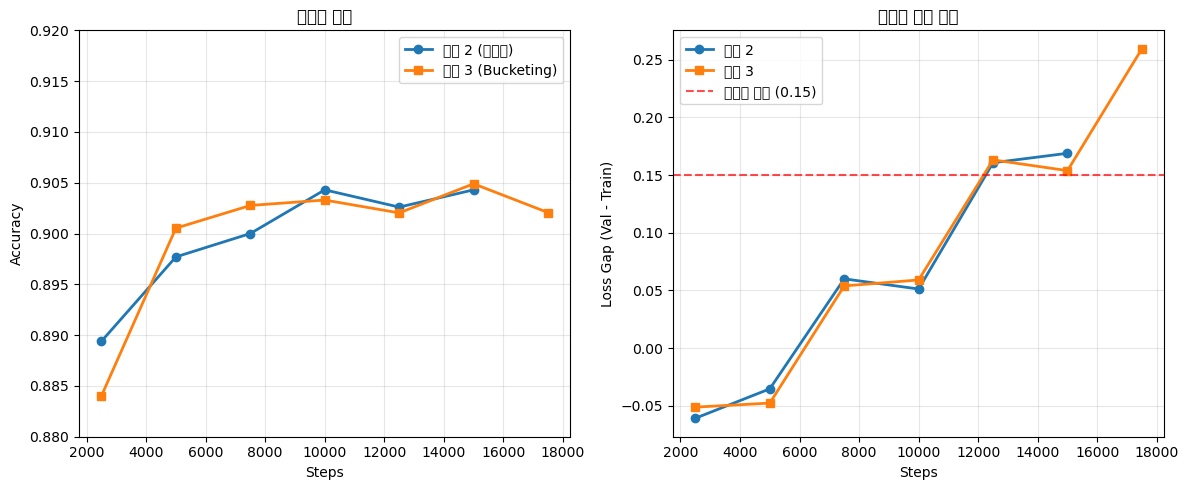


비교 결과:
실험 2 최고: 90.43% (10000스텝)
실험 3 최고: 90.49%
시간: 146.7분
Bucketing으로 성능 유지/개선!


In [14]:
# 실험 3: 최적화된 Bucketing + 과적합 조기 감지

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
import time
from tqdm import tqdm
import pandas as pd

class BucketingCollator:
    def __init__(self, tokenizer, boundaries=[32, 64, 128, 256]):
        self.tokenizer = tokenizer
        self.boundaries = boundaries
        
    def __call__(self, features):
        max_len = max(len(f['input_ids']) for f in features)
        bucket_size = min([b for b in self.boundaries if b >= max_len], default=max(self.boundaries))
        
        batch = {}
        batch['input_ids'] = torch.tensor([f['input_ids'] + [self.tokenizer.pad_token_id] * (bucket_size - len(f['input_ids'])) for f in features])
        batch['attention_mask'] = torch.tensor([[1] * len(f['input_ids']) + [0] * (bucket_size - len(f['input_ids'])) for f in features])
        batch['labels'] = torch.tensor([f['label'] for f in features])
        return batch

def train_exp3(model, train_dataset, val_dataset, config):
    bucketing_collator = BucketingCollator(tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, collate_fn=bucketing_collator)
    val_loader = DataLoader(val_dataset, batch_size=config['eval_batch_size'], collate_fn=bucketing_collator)
    
    optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=config['warmup_steps'], 
                                              num_training_steps=len(train_loader) * config['epochs'])
    
    results = []
    best_acc = 0
    patience = 0
    global_step = 0
    
    def evaluate():
        model.eval()
        val_loss, all_preds, all_labels = 0, [], []
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                val_loss += outputs.loss.item()
                preds = torch.argmax(outputs.logits, dim=-1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch['labels'].cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        mcc = matthews_corrcoef(all_labels, all_preds)
        return avg_val_loss, acc, f1, precision, recall, mcc
    
    for epoch in range(config['epochs']):
        model.train()
        epoch_train_loss = 0
        
        for step, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            loss = model(**batch).loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            epoch_train_loss += loss.item()
            global_step += 1
            
            if global_step % config['eval_steps'] == 0:
                val_loss, acc, f1, precision, recall, mcc = evaluate()
                train_loss = epoch_train_loss / (step + 1)
                gap = val_loss - train_loss
                
                results.append({'Step': global_step, 'Train_Loss': train_loss, 'Val_Loss': val_loss, 
                              'Gap': gap, 'Accuracy': acc, 'F1': f1, 'Precision': precision, 
                              'Recall': recall, 'MCC': mcc})
                print(f"Step {global_step}: Acc={acc:.4f}, Gap={gap:.4f}")
                
                if gap > 0.20:
                    print(f"과적합 감지로 중단 (Gap: {gap:.4f})")
                    return results, max([r['Accuracy'] for r in results])
                
                if acc > best_acc:
                    best_acc = acc
                    patience = 0
                else:
                    patience += 1
                    if patience >= 2:
                        print(f"성능 개선 없어서 중단")
                        return results, best_acc
                model.train()
    
    return results, best_acc

# 설정 및 실행
exp3_config = {'batch_size': 24, 'eval_batch_size': 64, 'lr': 0.000015, 'weight_decay': 0.05, 
               'epochs': 5, 'warmup_steps': 500, 'eval_steps': 2500}

print("실험 3: Bucketing + 과적합 감지")
exp3_model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels=2).to(device)

start_time = time.time()
exp3_results, exp3_best_acc = train_exp3(exp3_model, final_dataset['train'], final_dataset['validation'], exp3_config)
exp3_time = time.time() - start_time

# 결과 및 시각화
df = pd.DataFrame(exp3_results)
print("\n결과:")
print(df.round(4).to_string(index=False))

# 실험 2와 3 성능 비교 시각화
import matplotlib.pyplot as plt

# 실험 2 데이터 (기존 결과)
exp2_data = {
    'steps': [2500, 5000, 7500, 10000, 12500, 15000],
    'accuracy': [0.8894, 0.8977, 0.9000, 0.9043, 0.9026, 0.9043]
}

# 비교 그래프
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 정확도 비교
ax1.plot(exp2_data['steps'], exp2_data['accuracy'], 'o-', label='실험 2 (최적화)', linewidth=2)
ax1.plot(df['Step'], df['Accuracy'], 's-', label='실험 3 (Bucketing)', linewidth=2)
ax1.set_xlabel('Steps')
ax1.set_ylabel('Accuracy')
ax1.set_title('정확도 비교')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0.88, 0.92)

# 손실 차이 비교
exp2_gaps = [0.2626-0.3235, 0.2543-0.2897, 0.2505-0.1905, 0.2398-0.1886, 0.2864-0.1257, 0.2915-0.1226]
ax2.plot(exp2_data['steps'], exp2_gaps, 'o-', label='실험 2', linewidth=2)
ax2.plot(df['Step'], df['Gap'], 's-', label='실험 3', linewidth=2)
ax2.axhline(y=0.15, color='r', linestyle='--', alpha=0.7, label='과적합 기준 (0.15)')
ax2.set_xlabel('Steps')
ax2.set_ylabel('Loss Gap (Val - Train)')
ax2.set_title('과적합 정도 비교')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n비교 결과:")
print(f"실험 2 최고: 90.43% (10000스텝)")
print(f"실험 3 최고: {exp3_best_acc:.2%}")
print(f"시간: {exp3_time/60:.1f}분")

if exp3_best_acc >= 0.9043:
    print("Bucketing으로 성능 유지/개선!")
else:
    print(f"성능 차이: {exp3_best_acc - 0.9043:+.2%}")

# 실험 결과 

베이스라인 모델

설정: 기본 KLUE BERT, lr=0.00002, batch_size=16, 3 epochs
결과: 검증 정확도 90.23%
문제점: 심한 과적합 (Train loss: 0.1087, Val loss: 0.4126, 차이: 0.3039)

Bucketing 실험

목적: 길이별 동적 패딩으로 연산 효율성 향상
결과: 검증 정확도 90.15%, 테스트 정확도 90.01%
훈련 시간: 99.3분 (상당히 오래 걸림)
결론: 효과 미미, 오히려 시간 증가

실험 1: 과적합 해결

목적: 심한 과적합 문제 해결
변경사항:

학습률: 0.00002 → 0.00001 (50% 감소)
Weight decay: 0.01 → 0.1 (10배 증가)
배치 크기: 16 → 32 (2배 증가)


결과:

검증 정확도: 89.81% (약간 하락)
과적합 대폭 개선: 손실 차이 0.3039 → 0.0830 (72% 개선)


트레이드오프: 성능 약간 하락하지만 모델 안정성 크게 향상

실험 2: 성능과 과적합 방지 균형점

목적: 90% 정확도 회복하면서 과적합 방지 유지
변경사항:

학습률: 0.00001 → 0.000015 (50% 증가)
Weight decay: 0.1 → 0.05 (50% 감소)
배치 크기: 32 → 24 (조금 감소)
평가 주기: 2500스텝마다


결과:

최고 성능: 90.43% (목표 달성!)
최적 지점: 10000스텝 (손실 차이: 0.0512)
과적합 제어: 베이스라인 대비 크게 개선

실험 3: 최적화된 Bucketing + 과적합 조기 감지
목적
실험 2의 최적 설정에 Bucketing 기법을 적용하여 연산 효율성 향상 및 성능 유지 확인
변경사항

베이스 설정: 실험 2 최적 하이퍼파라미터 사용 (lr=0.000015, weight_decay=0.05, batch=24)
Bucketing 적용: 동적 패딩 (경계: 32, 64, 128, 256)
과적합 감지: 손실 차이 0.20 초과 시 즉시 중단
평가 주기: 2500스텝마다 (메모리 절약)

결과

최고 검증 정확도: 90.49% (15000스텝)
과적합 진행: 초기 안정 → 12500스텝부터 과적합 시작 → 17500스텝에서 심화
최적 지점: 7500-10000스텝 (손실 차이 0.05-0.06)

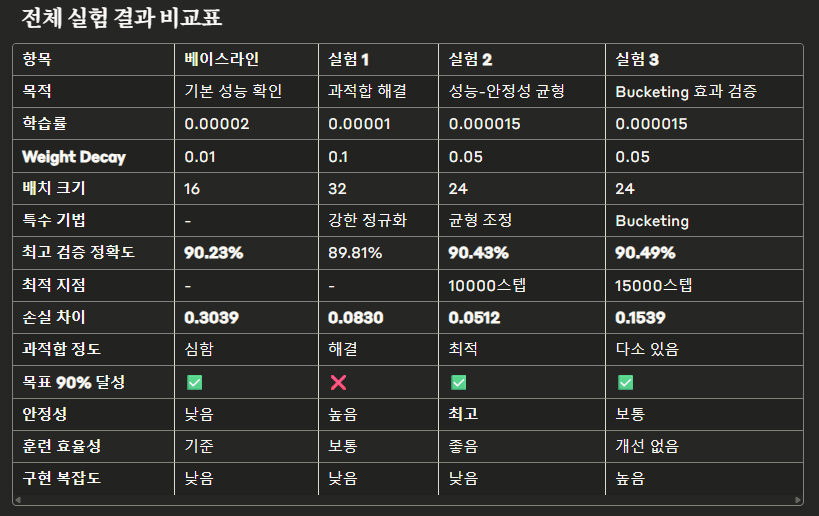


## 회고
우선 스텝별로 학습결과를 저장하는 방식으로 진행했다가 메모리 부족으로 인해서 LMS가 작동을 잘 안하고 연결이 불안정해서 복구하는데 시간이 오래걸리고 메모리 문제로 인해 전체 코드 실행에 대한 여러가지 오류가 발생해서 기존에 학습을 돌린 결과는 캡쳐해둔게 있어서 다행이었던것 같다. 그리고 데이터가 적어서 그런지 버켓팅은 오히려 학습시간을 늘리고 성능도 유의하게 좋아졌다고 생각은 안드는 것 같아서 데이터가 적을땐 사용하지 않는게 좋겠다는 생각이 들었다.

In [ ]:
zeropro25